In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from conda.instructions import PRINT

# NSS parameters from St-Louis Fed
beta0 = 3.385571197
beta1 = 0.938107702
beta2 = -7.40E-05
beta3 = 4.296030822
tau1 = 1.227066261
tau2 = 18.49221165

# Define NSS curve function
def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

# Observed AA yields
maturities = np.array([0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30])
aa_yields = np.array([4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77])

# Get treasury yields
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)

# Get credit spread
credit_spreads = aa_yields - risk_free_yields

# Store results
df_results = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Risk-Free Yield (%)': risk_free_yields.round(2),
    'AA Yield (%)': aa_yields,
    'Credit Spread (bps)': credit_spreads.round(4) * 100  # Convert to basis points
})

df_results

,Maturity (Years),Risk-Free Yield (%),AA Yield (%),Credit Spread (bps)
0,0.5,4.21,4.50,28.69
1,1.0,4.14,4.53,39.08
2,2.0,4.06,4.59,52.54
3,3.0,4.05,4.66,61.10
4,4.0,4.07,4.73,66.50
5,5.0,4.10,4.81,71.21
6,7.0,4.18,5.01,82.62
7,10.0,4.32,5.28,96.26
8,12.0,4.40,5.42,102.32
9,15.0,4.50,5.55,105.38


Step 1 parameters: r0=0.0405, kappa_r=0.0044, theta_r=0.1500, sigma_r=0.0003
Optimization error: 0.00001564
Feller condition: 2κθ/σ² = 14893.4316 ✓
Step 2 parameters: s0=0.029073, kappa_s=0.1275, theta_s=0.048557, sigma_s=0.0090, alpha=0.015726, beta=-0.0268
Optimization error: 0.00001137
Feller condition for spread process: 2κθ/σ² = 151.3746 ✓

===== Duffee Model Calibration Summary =====
Risk-Free Yield Curve Parameters (Step 1):
  r0 (initial short rate): 0.040537
  kappa_r (mean-reversion speed): 0.004393
  theta_r (long-term mean): 0.150000
  sigma_r (volatility): 0.000297

Defaultable Yield Curve Parameters (Step 2):
  s0 (initial credit spread): 0.029073
  kappa_s (credit spread mean-reversion speed): 0.127547
  theta_s (credit spread long-term mean): 0.048557
  sigma_s (credit spread volatility): 0.009046
  alpha (constant risk premium): 0.015726
  beta (risk sensitivity coefficient): -0.026827

Fit Quality Metrics:
  Risk-Free Yield RMSE: 0.000757
  AA Yield RMSE: 0.000651


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


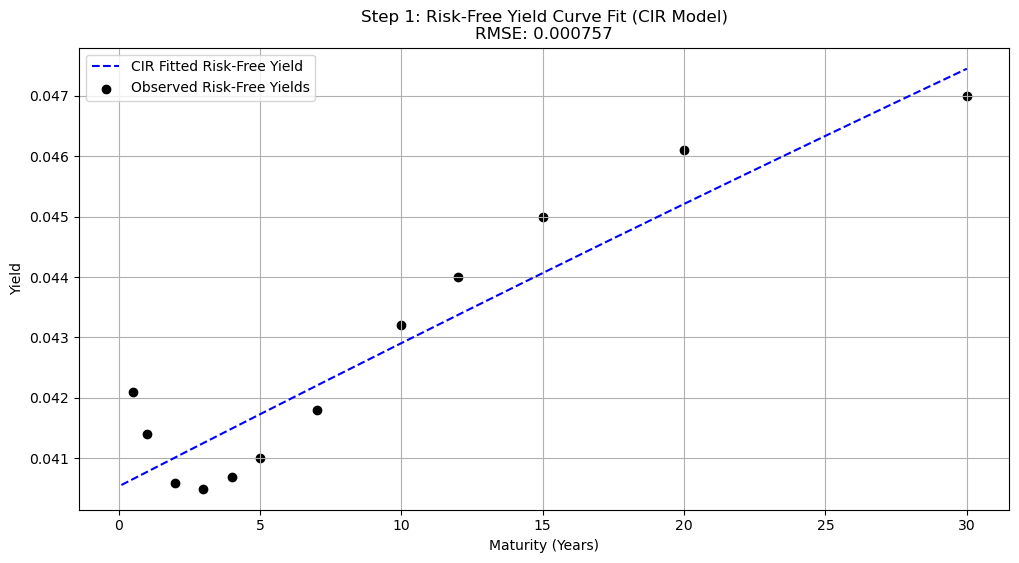

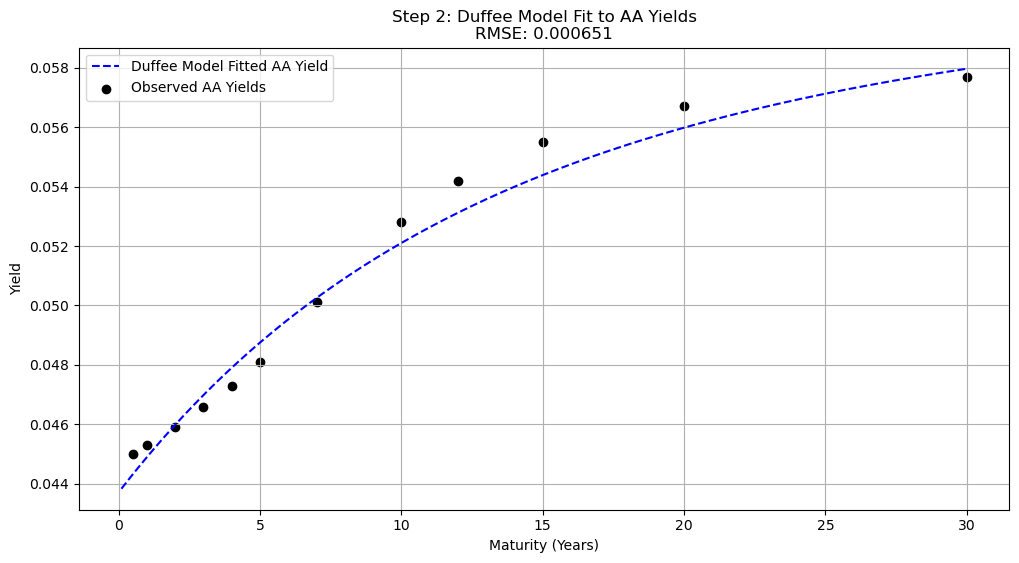

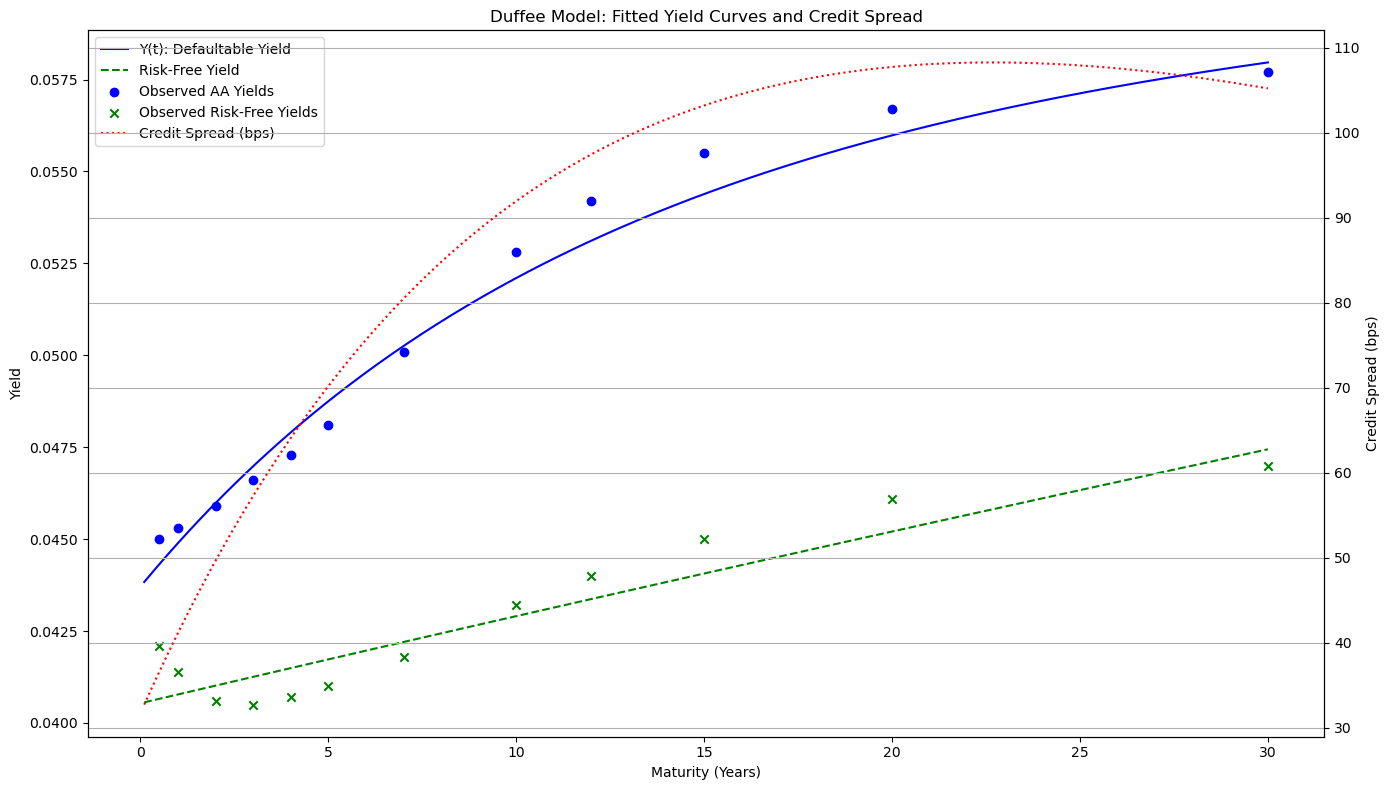


===== Non-Callable Bond =====
Price: $959681.76
YTM: 4.8751%


In [13]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Define the CIR model zero-coupon bond price formula
def cir_zero_coupon_bond_price(r, kappa, theta, sigma, T):
    """
    Calculate zero-coupon bond price under CIR model
    """
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    denominator = 2 * gamma + (kappa + gamma) * (np.exp(gamma * T) - 1)
    A = ((2 * gamma * np.exp((kappa + gamma) * T / 2)) / denominator) ** (2 * kappa * theta / sigma**2)
    B = 2 * (np.exp(gamma * T) - 1) / denominator
    price = A * np.exp(-B * r)
    return price, A, B

# Define the CIR model zero-coupon yield formula
def cir_zero_coupon_yield(r, kappa, theta, sigma, T):
    """
    Calculate zero-coupon yield under CIR model
    """
    price, _, _ = cir_zero_coupon_bond_price(r, kappa, theta, sigma, T)
    yield_value = -np.log(price) / T
    return yield_value

# Two-step calibration class based on the Duffee model
class DuffeeModelTwoStep:
    def __init__(self, df_results):
        self.df_results = df_results
        self.maturities = df_results['Maturity (Years)'].values
        self.rf_yields = df_results['Risk-Free Yield (%)'].values / 100  # Convert to decimal
        self.aa_yields = df_results['AA Yield (%)'].values / 100  # Convert to decimal

    # Step 1: Calibrate the risk-free zero-coupon yield curve
    def fit_step1_risk_free(self):
        def objective_rf(params):
            r0, kappa_r, theta_r, sigma_r = params
            # Add constraint for model validity
            if sigma_r**2 >= 2*kappa_r*theta_r or theta_r <= 0 or r0 <= 0:  
                return float('inf')
            
            rf_theo = [cir_zero_coupon_yield(r0, kappa_r, theta_r, sigma_r, t) for t in self.maturities]
            # Weight short-term rates more heavily
            weights = [3.0 if t <= 5.0 else 1.0 for t in self.maturities]
            weighted_errors = [(theo - obs)**2 * w for theo, obs, w in zip(rf_theo, self.rf_yields, weights)]
            return np.sum(weighted_errors)

        # Initial parameter guesses
        initial_sets = [
            [0.04, 0.01, 0.07, 0.02],
            [0.04, 0.005, 0.08, 0.02],
            [0.035, 0.015, 0.1, 0.015],
            [0.045, 0.02, 0.1, 0.02],
            [0.039,0.0028,0.215,0.0003]
        ]
        bounds = [(0.001, 0.1), (0.0001, 5.0), (0.01, 0.15), (0.0001, 0.5)]

        best_result = None
        min_error = float('inf')

        for initial in initial_sets:
            result = optimize.minimize(objective_rf, initial, method='L-BFGS-B', bounds=bounds)
            if result.fun < min_error:
                min_error = result.fun
                best_result = result

        self.r0, self.kappa_r, self.theta_r, self.sigma_r = best_result.x
        print(f"Step 1 parameters: r0={self.r0:.4f}, kappa_r={self.kappa_r:.4f}, theta_r={self.theta_r:.4f}, sigma_r={self.sigma_r:.4f}")
        print(f"Optimization error: {min_error:.8f}")
        
        # Verify Feller condition
        feller = 2*self.kappa_r*self.theta_r / (self.sigma_r**2)
        print(f"Feller condition: 2κθ/σ² = {feller:.4f} {'✓' if feller > 1 else '✗'}")

    # Step 2: Calibrate the defaultable (AA-rated) zero-coupon yield curve
    def fit_step2_defaultable(self):
        def objective_credit(params):
            s0, kappa_s, theta_s, sigma_s, alpha, beta = params
            
            # Check Feller condition for the spread process
            if sigma_s**2 >= 2*kappa_s*theta_s or theta_s <= 0 or s0 <= 0:
                return float('inf')

            # Calculate defaultable yields
            defaultable_yields = []
            for t in self.maturities:
                y = self.calculate_defaultable_yield(t, s0, kappa_s, theta_s, sigma_s, alpha, beta)
                defaultable_yields.append(y)

            # Weight short-term rates more heavily
            weights = [5.0 if t <= 5.0 else 1.0 for t in self.maturities]
            weighted_errors = [(theo - obs)**2 * w for theo, obs, w in zip(defaultable_yields, self.aa_yields, weights)]
            return np.sum(weighted_errors)

        # Initial parameter guesses
        initial_sets = [
            [0.002, 0.1, 0.01, 0.01, 0.001, -0.1],
            [0.04,0.006,0.33,0.06,0.04,-0.01],
            [0.028,0.125,0.046,0.046,0.00126,-0.648]
        ]
        bounds = [(0.00001, 0.05), (0.0001, 3.0), (0.0001, 0.05), (0.0001, 0.5), (0.001, 0.02), (-1.0, -0.001)]

        best_result = None
        min_error = float('inf')

        for initial in initial_sets:
            result = optimize.minimize(objective_credit, initial, method='L-BFGS-B', bounds=bounds)
            if result.fun < min_error:
                min_error = result.fun
                best_result = result

        self.s0, self.kappa_s, self.theta_s, self.sigma_s, self.alpha, self.beta = best_result.x
        print(f"Step 2 parameters: s0={self.s0:.6f}, kappa_s={self.kappa_s:.4f}, theta_s={self.theta_s:.6f}, sigma_s={self.sigma_s:.4f}, alpha={self.alpha:.6f}, beta={self.beta:.4f}")
        print(f"Optimization error: {min_error:.8f}")
        
        # Verify Feller condition for spread process
        feller = 2*self.kappa_s*self.theta_s / (self.sigma_s**2)
        print(f"Feller condition for spread process: 2κθ/σ² = {feller:.4f} {'✓' if feller > 1 else '✗'}")
    
    def calculate_defaultable_yield(self, T, s0=None, kappa_s=None, theta_s=None, sigma_s=None, alpha=None, beta=None):
        """
        Calculate defaultable yield using the Duffee model formula
        """
        # Use provided parameters or instance parameters
        s0 = s0 if s0 is not None else self.s0
        kappa_s = kappa_s if kappa_s is not None else self.kappa_s
        theta_s = theta_s if theta_s is not None else self.theta_s
        sigma_s = sigma_s if sigma_s is not None else self.sigma_s
        alpha = alpha if alpha is not None else self.alpha
        beta = beta if beta is not None else self.beta
        
        # Calculate a_cir and b_cir for the scaled risk-free process
        # Let 𝑎𝑐𝑖𝑟,1(𝑇) denote the function calculated with 𝜅𝑟, (1 + 𝛽)𝜃𝑟 and √(1 + 𝛽)𝜎𝑟
        scaled_theta_r1 = (1 + beta) * self.theta_r
        scaled_sigma_r1 = self.sigma_r * np.sqrt(1 + beta)
        _, a_cir_1, b_cir_1 = cir_zero_coupon_bond_price(self.r0, self.kappa_r, scaled_theta_r1, scaled_sigma_r1, T)
        
        # Calculate a_cir and b_cir for the spread process
        _, a_cir_2, b_cir_2 = cir_zero_coupon_bond_price(s0, kappa_s, theta_s, sigma_s, T)
        
        # Calculate a_cir and b_cir for the original risk-free process
        _, a_cir_3, b_cir_3 = cir_zero_coupon_bond_price(self.r0, self.kappa_r, self.theta_r, self.sigma_r, T)
        
        # Calculate defaultable yield
        yield_term = -1/T * (
            -alpha * T +
            np.log(a_cir_1) - b_cir_1 * (1 + beta) * self.r0 +
            np.log(a_cir_2) - b_cir_2 * s0 -
            np.log(a_cir_3) + b_cir_3 * self.r0
        )
        
        return yield_term
    
    def calculate_defaultable_zcb_price(self, T, r=None, s=None):
        """
        Calculate defaultable zero-coupon bond price directly
        """
        r = r if r is not None else self.r0
        s = s if s is not None else self.s0
        
        # Calculate a_cir and b_cir for the scaled risk-free process
        scaled_theta_r1 = (1 + self.beta) * self.theta_r
        scaled_sigma_r1 = self.sigma_r * np.sqrt(1 + self.beta)
        _, a_cir_1, b_cir_1 = cir_zero_coupon_bond_price(r, self.kappa_r, scaled_theta_r1, scaled_sigma_r1, T)
        
        # Calculate a_cir and b_cir for the spread process
        _, a_cir_2, b_cir_2 = cir_zero_coupon_bond_price(s, self.kappa_s, self.theta_s, self.sigma_s, T)
        
        # Calculate a_cir and b_cir for the original risk-free process
        _, a_cir_3, b_cir_3 = cir_zero_coupon_bond_price(r, self.kappa_r, self.theta_r, self.sigma_r, T)
        
        # Calculate P_cir components
        P_cir_1 = a_cir_1 * np.exp(-b_cir_1 * (1 + self.beta) * r)
        P_cir_2 = a_cir_2 * np.exp(-b_cir_2 * s)
        P_cir_3 = a_cir_3 * np.exp(-b_cir_3 * r)
        
        # Calculate zero-coupon bond price
        zcb_price = np.exp(-self.alpha * T) * (P_cir_1 * P_cir_2) / P_cir_3
        
        return zcb_price
    
    def calculate_non_callable_bond_price(self, face_value=1000000, coupon_rate=0.04, coupon_freq=2, T=5):
        """
        Calculate price of a non-callable bond using the Duffee model.
        Bond pays coupons periodically and principal at maturity.
        """
        # Bond specs
        coupon = face_value * coupon_rate / coupon_freq
        
        # Calculate present value of all cash flows
        bond_price = 0
        
        # Discount coupons
        for i in range(1, int(T * coupon_freq) + 1):
            t = i / coupon_freq
            zcb_price = self.calculate_defaultable_zcb_price(t)
            bond_price += coupon * zcb_price
        
        # Discount principal
        zcb_price_maturity = self.calculate_defaultable_zcb_price(T)
        bond_price += face_value * zcb_price_maturity
        
        return bond_price
    
    def plot_risk_free_fit(self):
        """Plot risk-free yield curve fit results"""
        t_range = np.linspace(0.1, 30, 300)
        rf_fitted = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in t_range]
        
        # Calculate RMSE
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in self.maturities]
        rmse = np.sqrt(np.mean((np.array(rf_theo) - self.rf_yields) ** 2))
        
        plt.figure(figsize=(12, 6))
        plt.plot(t_range, rf_fitted, label='CIR Fitted Risk-Free Yield', linestyle='--', color='blue')
        plt.scatter(self.maturities, self.rf_yields, color='black', label='Observed Risk-Free Yields')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.title(f'Step 1: Risk-Free Yield Curve Fit (CIR Model)\nRMSE: {rmse:.6f}')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def plot_defaultable_fit(self):
        """Plot AA-rated bond yield curve fit results"""
        t_range = np.linspace(0.1, 30, 300)
        
        # Calculate theoretical defaultable yields
        aa_fitted = [self.calculate_defaultable_yield(t) for t in t_range]
        
        # Calculate RMSE
        aa_theo = [self.calculate_defaultable_yield(t) for t in self.maturities]
        rmse = np.sqrt(np.mean((np.array(aa_theo) - self.aa_yields) ** 2))
        
        plt.figure(figsize=(12, 6))
        plt.plot(t_range, aa_fitted, label='Duffee Model Fitted AA Yield', linestyle='--', color='blue')
        plt.scatter(self.maturities, self.aa_yields, color='black', label='Observed AA Yields')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.title(f'Step 2: Duffee Model Fit to AA Yields\nRMSE: {rmse:.6f}')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def plot_combined_yield_curves(self):
        """Plot combined yield curves and credit spread"""
        t_range = np.linspace(0.1, 30, 300)
        
        # Calculate theoretical risk-free yields
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in t_range]
        
        # Calculate theoretical defaultable yields
        aa_fitted = [self.calculate_defaultable_yield(t) for t in t_range]
        
        # Calculate credit spreads
        credit_spreads = [(aa - rf) * 10000 for aa, rf in zip(aa_fitted, rf_theo)]  # Convert to basis points
        
        # Create figure with dual y-axes
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Left y-axis: Yields
        ax1.plot(t_range, aa_fitted, label='Y(t): Defaultable Yield', color='blue')
        ax1.plot(t_range, rf_theo, label='Risk-Free Yield', color='green', linestyle='--')
        ax1.scatter(self.maturities, self.aa_yields, label='Observed AA Yields', color='blue', marker='o')
        ax1.scatter(self.maturities, self.rf_yields, label='Observed Risk-Free Yields', color='green', marker='x')
        ax1.set_xlabel('Maturity (Years)')
        ax1.set_ylabel('Yield')
        ax1.tick_params(axis='y')
        
        # Right y-axis: Credit spread (basis points)
        ax2 = ax1.twinx()
        ax2.plot(t_range, credit_spreads, label='Credit Spread (bps)', color='red', linestyle=':')
        ax2.set_ylabel('Credit Spread (bps)')
        ax2.tick_params(axis='y')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
        
        plt.title('Duffee Model: Fitted Yield Curves and Credit Spread')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    def print_optimization_summary(self):
        """Print optimization results summary"""
        print("\n===== Duffee Model Calibration Summary =====")
        print("Risk-Free Yield Curve Parameters (Step 1):")
        print(f"  r0 (initial short rate): {self.r0:.6f}")
        print(f"  kappa_r (mean-reversion speed): {self.kappa_r:.6f}")
        print(f"  theta_r (long-term mean): {self.theta_r:.6f}")
        print(f"  sigma_r (volatility): {self.sigma_r:.6f}")
        
        print("\nDefaultable Yield Curve Parameters (Step 2):")
        print(f"  s0 (initial credit spread): {self.s0:.6f}")
        print(f"  kappa_s (credit spread mean-reversion speed): {self.kappa_s:.6f}")
        print(f"  theta_s (credit spread long-term mean): {self.theta_s:.6f}")
        print(f"  sigma_s (credit spread volatility): {self.sigma_s:.6f}")
        print(f"  alpha (constant risk premium): {self.alpha:.6f}")
        print(f"  beta (risk sensitivity coefficient): {self.beta:.6f}")
        
        # Calculate fit quality metrics
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in self.maturities]
        rf_rmse = np.sqrt(np.mean((np.array(rf_theo) - self.rf_yields) ** 2))
        
        aa_theo = [self.calculate_defaultable_yield(t) for t in self.maturities]
        aa_rmse = np.sqrt(np.mean((np.array(aa_theo) - self.aa_yields) ** 2))
        
        print("\nFit Quality Metrics:")
        print(f"  Risk-Free Yield RMSE: {rf_rmse:.6f}")
        print(f"  AA Yield RMSE: {aa_rmse:.6f}")
        print("========================================")

    
# Function to calculate YTM from bond price
def bond_price_to_ytm(price, face_value, coupon_rate, coupon_freq, T):
    """Calculate yield-to-maturity from bond price using the Newton-Raphson method"""
    coupon = face_value * coupon_rate / coupon_freq
    periods = int(T * coupon_freq)

    def f(y):
        pv = 0
        for i in range(1, periods + 1):
            t = i / coupon_freq
            pv += coupon * np.exp(-y * t)
        pv += face_value * np.exp(-y * T)
        return pv - price

    def df(y):
        dpv = 0
        for i in range(1, periods + 1):
            t = i / coupon_freq
            dpv -= coupon * t * np.exp(-y * t)
        dpv -= face_value * T * np.exp(-y * T)
        return dpv

    y = 0.05  # initial guess

    for _ in range(100):
        f_val = f(y)
        if abs(f_val) < 1e-10:
            break
        df_val = df(y)
        if abs(df_val) < 1e-10:
            break
        y_new = y - f_val / df_val
        if abs(y_new - y) < 1e-10:
            break
        y = y_new

    return y

def run_calibration(df_results):
    model = DuffeeModelTwoStep(df_results)
    model.fit_step1_risk_free()
    model.fit_step2_defaultable()
    model.print_optimization_summary()
    model.plot_risk_free_fit()
    model.plot_defaultable_fit()
    model.plot_combined_yield_curves()
    return model

def run_bond_valuation(model, face_value=1000000, coupon_rate=0.04, coupon_freq=2, T=5):
    non_callable_price = model.calculate_non_callable_bond_price(face_value, coupon_rate, coupon_freq, T)
    non_callable_ytm = model.calculate_defaultable_yield(T)
    print(f"\n===== Non-Callable Bond =====")
    print(f"Price: ${non_callable_price:.2f}")
    print(f"YTM: {non_callable_ytm:.4%}")
    return non_callable_price, non_callable_ytm

def main():
    data = {
        'Maturity (Years)': [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 12.0, 15.0, 20.0, 30.0],
        'Risk-Free Yield (%)': [4.21, 4.14, 4.06, 4.05, 4.07, 4.10, 4.18, 4.32, 4.40, 4.50, 4.61, 4.70],
        'AA Yield (%)': [4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77],
    }
    data['Credit Spread (bps)'] = [(aa - rf) * 100 for aa, rf in zip(data['AA Yield (%)'], data['Risk-Free Yield (%)'])]
    df_results = pd.DataFrame(data)
    
    model = run_calibration(df_results)
    
    face_value = 1000000
    coupon_rate = 0.04
    coupon_freq = 2
    T = 5
    
    non_callable_price, non_callable_ytm = run_bond_valuation(model, face_value, coupon_rate, coupon_freq, T)

if __name__ == "__main__":
    main()

### Evaluate AA Corp Bond with Explicit Finite Scheme 

In [168]:
import numpy as np

# Function to calculate the bond price
def calculate_callable_bond_price(model, face_value=1000000, coupon_rate=0.04, coupon_freq=2, T=5):
    # Duffee (1999) model parameters
    r0 = model.r0
    kappa_r = model.kappa_r
    theta_r = model.theta_r
    sigma_r = model.sigma_r

    s0 = model.s0
    kappa_s = model.kappa_s
    theta_s = model.theta_s
    sigma_s = model.sigma_s

    alpha = model.alpha
    beta = model.beta

    # Bond specs
    coupon = face_value * coupon_rate / coupon_freq

    # Grid specs
    N_t = 1000
    N_r = 100
    N_s = 100
    r_max = 0.15
    s_max = 0.10

    dt = T / N_t
    dr = r_max / N_r
    ds = s_max / N_s

    time_grid = np.linspace(0, T, N_t + 1)
    r_grid = np.linspace(0, r_max, N_r + 1)  # Start from 0, not dr
    s_grid = np.linspace(0, s_max, N_s + 1)  # Start from 0, not ds

    # Initialize bond value grid
    V = np.zeros((N_r + 1, N_s + 1))

    # Terminal condition - face value at maturity
    V[:, :] = face_value

    # Locate initial position
    r_idx = min(np.searchsorted(r_grid, r0), N_r)
    s_idx = min(np.searchsorted(s_grid, s0), N_s)

    # Precompute coefficients
    def lambda_fn(r, s):
        return alpha + beta * r + s

    # Create arrays to store coupon payment times
    coupon_times = np.arange(coupon_freq * T) / coupon_freq
    coupon_times = coupon_times[coupon_times > 0]  # Remove time 0

    # Time-stepping backwards
    for n in reversed(range(N_t)):
        t = time_grid[n]
        V_new = np.copy(V)
        
        # Calculate non-callable bond value at this time for boundary conditions
        # Simple approximation: discount remaining cash flows at risk-free rate
        remaining_T = T - t
        num_remaining_coupons = int(np.ceil(remaining_T * coupon_freq))
        non_callable_values = np.zeros((N_r + 1, N_s + 1))
        
        for i in range(N_r + 1):
            r = r_grid[i]
            r = max(r, 1e-6)  # Avoid division by zero
            
            for j in range(N_s + 1):
                s = s_grid[j]
                s = max(s, 1e-6)  # Avoid division by zero
                lam = lambda_fn(r, s)
                
                # Approximate discount factors for each cash flow
                value = 0
                for k in range(num_remaining_coupons):
                    payment_time = (k + 1) / coupon_freq
                    if payment_time <= remaining_T:
                        df = np.exp(-(r + lam) * payment_time)
                        value += coupon * df
                
                # Add discounted principal
                df_principal = np.exp(-(r + lam) * remaining_T)
                value += face_value * df_principal
                non_callable_values[i, j] = value
        
        # Boundary conditions
        # At r = 0 (left boundary)
        V_new[0, :] = non_callable_values[0, :]
        
        # At r = r_max (right boundary)
        V_new[N_r, :] = non_callable_values[N_r, :]
        
        # At s = 0 (bottom boundary)
        V_new[:, 0] = non_callable_values[:, 0]
        
        # At s = s_max (top boundary)
        V_new[:, N_s] = non_callable_values[:, N_s]
        
        # Interior points
        for i in range(1, N_r):
            for j in range(1, N_s):
                r = r_grid[i]
                s = s_grid[j]
                r = max(r, 1e-6)
                s = max(s, 1e-6)
                lam = lambda_fn(r, s)

                # Finite differences 
                dV_dr = (V[i+1, j] - V[i-1, j]) / (2 * dr)
                d2V_dr2 = (V[i+1, j] - 2 * V[i, j] + V[i-1, j]) / (dr**2)
                dV_ds = (V[i, j+1] - V[i, j-1]) / (2 * ds) 
                d2V_ds2 = (V[i, j+1] - 2 * V[i, j] + V[i, j-1]) / (ds**2)  

                A = kappa_r * (theta_r - r) * dV_dr + 0.5 * sigma_r**2 * r * d2V_dr2
                B = kappa_s * (theta_s - s) * dV_ds + 0.5 * sigma_s**2 * s * d2V_ds2
                C = -(r + lam) * V[i, j]

                V_new[i, j] = V[i, j] + dt * (A + B + C)

                # Call option: enforce call at par
                V_new[i, j] = min(V_new[i, j], face_value)  

        # Coupon payment at discrete times
        # Check if there's a coupon payment at this time point
        time_to_maturity = T - t
        if any(abs(time_to_maturity - cp_time) < dt/2 for cp_time in coupon_times):
            V_new += coupon

        # Update
        V = np.copy(V_new)

    # Final price
    bond_price = V[r_idx, s_idx]
    return bond_price


# Create model instance
data = {
    'Maturity (Years)': [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 12.0, 15.0, 20.0, 30.0],
    'Risk-Free Yield (%)': [4.21, 4.14, 4.06, 4.05, 4.07, 4.10, 4.18, 4.32, 4.40, 4.50, 4.61, 4.70],
    'AA Yield (%)': [4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77],
}

# Calculate credit spreads (bps)
data['Credit Spread (bps)'] = [(aa - rf) * 100 for aa, rf in zip(data['AA Yield (%)'], data['Risk-Free Yield (%)'])]

df_results = pd.DataFrame(data)

# Calculate bond price
face_value = 1000000
coupon_rate = 0.04
coupon_freq = 2
T = 5  # years

bond_price = calculate_callable_bond_price(model, face_value, coupon_rate, coupon_freq, T)
print(f"Callable bond price: ${bond_price:.2f}")

callable_price = bond_price  # Example value - in practice would be from finite difference solution

# Calculate implied YTM for callable bond (using standard bond pricing formula)
def bond_price_to_ytm(price, face_value, coupon_rate, coupon_freq, T):
    """Convert bond price to yield-to-maturity using binary search"""
    coupon = face_value * coupon_rate / coupon_freq
    
    def present_value(y):
        pv = 0
        for i in range(1, int(T * coupon_freq) + 1):
            t = i / coupon_freq
            pv += coupon * np.exp(-y * t)
        pv += face_value * np.exp(-y * T)
        return pv
    
    def error(y):
        return present_value(y) - price
    
    # Binary search
    lower = 0.001  # 0.1%
    upper = 0.20   # 20%
    
    for _ in range(100):
        mid = (lower + upper) / 2
        if abs(error(mid)) < 0.01:
            return mid
        if error(mid) > 0:
            lower = mid
        else:
            upper = mid
            
    return (lower + upper) / 2

# Calculate YTM for callable bond
callable_yield = bond_price_to_ytm(callable_price, face_value, coupon_rate, coupon_freq, T)
print(f"Callable Bond YTM: {callable_yield:.4%}")



Callable bond price: $930022.64
Callable Bond YTM: 5.5474%
